In [24]:
import sys
if '../' not in sys.path:
    sys.path.append('../')
import utils.process as process
import utils.lstm as lstm
import matplotlib.pyplot as plt

# 1. Train best LSTM model

In [11]:
data = {'BATCH_SIZE': '64',
 'ADAM': '0.001',
 'NUM_LAYERS': '2',
 'DROPOUT': '0.1',
 'EMBED_DIM': '128',
 'INPUT_FEATURES': '3',
 'MAX_LEN': '77',
 'OUTPUT_FEATURES': '3',
 'PERIOD': '7',
 'MODEL': 'lstm' }

calc_folder = './best_lstm'

In [ ]:
lstm.run_lstm(int(data['BATCH_SIZE']),
                float(data['ADAM']),  
                int(data['NUM_LAYERS']),                
                int(data['EMBED_DIM']),
                int(data['PERIOD']),
                float(data['DROPOUT']),
                calc_folder=calc_folder,
                verbose=True,
                basefolder='../datasets')

# 2. Load trained model and evaluate ExplGPP(D,M)

In [13]:
calc_folder='./best_lstm'
data=lstm.load_card(calc_folder)

In [16]:
data_models={}

data_models['models'], data_models['ig_rescaled'], data_models['drivers_rescaled'] = lstm.load_lstm(int(data['BATCH_SIZE']),
                float(data['ADAM']),  
                int(data['NUM_LAYERS']),                
                int(data['EMBED_DIM']),
                int(data['PERIOD']),
                float(data['DROPOUT']),
                calc_folder=calc_folder,
                verbose=True, 
                epoch_to_load=50,
                basefolder='../datasets'
                )

(divide_into_periods) Output shape: (10000, 77, 3)
(divide_into_periods) Output shape: (10000, 77, 3)
(divide_into_periods) Output shape: (10000, 77, 3)
(divide_into_periods) Output shape: (10000, 77, 3)
(divide_into_periods) Output shape: (10000, 77, 3)
(divide_into_periods) Output shape: (10000, 77, 3)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 77, 3)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 77, 128)           67584     
                                                                 
 dropout_2 (Dropout)         (None, 77, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 77, 128)           131584    
                                                                 
 dropout_3 (Dropo

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 77, 3)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 77, 128)           67584     
                                                                 
 dropout_4 (Dropout)         (None, 77, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 77, 128)           131584    
                                                                 
 dropout_5 (Dropout)         (None, 77, 128)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 77, 3)             387       
                                                                 
Total params: 199555 (779.51 KB)
Trainable params: 199555 (

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 77, 3)]           0         
                                                                 
 lstm_6 (LSTM)               (None, 77, 128)           67584     
                                                                 
 dropout_6 (Dropout)         (None, 77, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 77, 128)           131584    
                                                                 
 dropout_7 (Dropout)         (None, 77, 128)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 77, 3)             387       
                                                                 
Total params: 199555 (779.51 KB)
Trainable params: 199555 (

CHECK: Do we recover the loss function printed during training?

In [18]:
import numpy as np
from tensorflow.keras.losses import MeanSquaredError

# Initialize the loss function
mse_loss = MeanSquaredError()


# Store results
losses = {}
n_training_data = 8000  # same as in training

data_models['y_train_pred']={}
data_models['y_test_pred']={}

for site in ['tropical','boreal','temperate']:
    # Training data
    X_train = data_models['ig_rescaled'][site][:n_training_data, :, :]
    y_train = data_models['drivers_rescaled'][site][:n_training_data, :, :]

    # Test/validation data
    X_test = data_models['ig_rescaled'][site][n_training_data:, :, :]
    y_test = data_models['drivers_rescaled'][site][n_training_data:, :, :]

    # Predictions
    data_models['y_train_pred'][site] = data_models['models'][site].predict(X_train, verbose=0)
    data_models['y_test_pred'][site] = data_models['models'][site].predict(X_test, verbose=0)

    # Compute MSE
    train_loss = mse_loss(y_train, data_models['y_train_pred'][site]).numpy()
    test_loss = mse_loss(y_test, data_models['y_test_pred'][site]).numpy()

    losses[site] = {'train_loss': train_loss, 'test_loss': test_loss}
    print(f"{site} - Train MSE: {train_loss:.6f}, Test MSE: {test_loss:.6f}")



tropical - Train MSE: 0.302039, Test MSE: 0.313245
boreal - Train MSE: 0.506368, Test MSE: 0.517491
temperate - Train MSE: 0.552307, Test MSE: 0.569431


In [ ]:

data_models['explained_variance_train']={}
data_models['explained_variance_test']={}

for site in ['tropical','boreal','temperate']:

    n_samples, n_times, n_features = data_models['ig_rescaled'][site].shape
    print(n_samples, n_times, n_features)
    data_models['explained_variance_train'][site]=np.zeros((n_times,n_features))
    data_models['explained_variance_test'][site]=np.zeros((n_times,n_features))

    for i in range(n_times):
        for f in range(n_features):

            # we do not have denominator since input features have been standardized
            num = np.var(data_models['y_train_pred'][site][:,i,f])
            data_models['explained_variance_train'][site][i,f] = num

            # we do not have denominator since input features have been standardized
            num = np.var(data_models['y_test_pred'][site][:,i,f])
            data_models['explained_variance_test'][site][i,f] = num            


10000 77 3
10000 77 3
10000 77 3


In [27]:
def decorate_plot(ax,lim=None,xlabel=True, fontsize=20, xtick_freq=1, fontsize_yticks=None):
    months = process.months
    names=months['name']*5
    starts=list(months['start']-2*365)+list(months['start']-365)+ \
                list(months['start'])+list(months['start']+365)+list(months['start']+2*365)
    starts=np.array(starts)
    pos=[]
    lab=[]
    for im in range(len(names)):
        try:
            pos.append( (starts[im]+starts[im+1])/2 )
            lab.append( names[im] )
            ax.axvline(x=starts[im], color='gray')
        except IndexError:
            pass
    if xlabel:
        ax.set_xticks(pos[::xtick_freq])
        ax.set_xticklabels(lab[::xtick_freq],rotation='vertical',fontsize=fontsize)
    else:
        ax.get_xaxis().set_visible(False)
    if fontsize_yticks is not None:
        ax.tick_params(axis='y', labelsize=fontsize_yticks)
    if lim is None:
        ax.set_xlim(x.min(),x.max())
    else:
        ax.set_xlim(lim[0],lim[1])

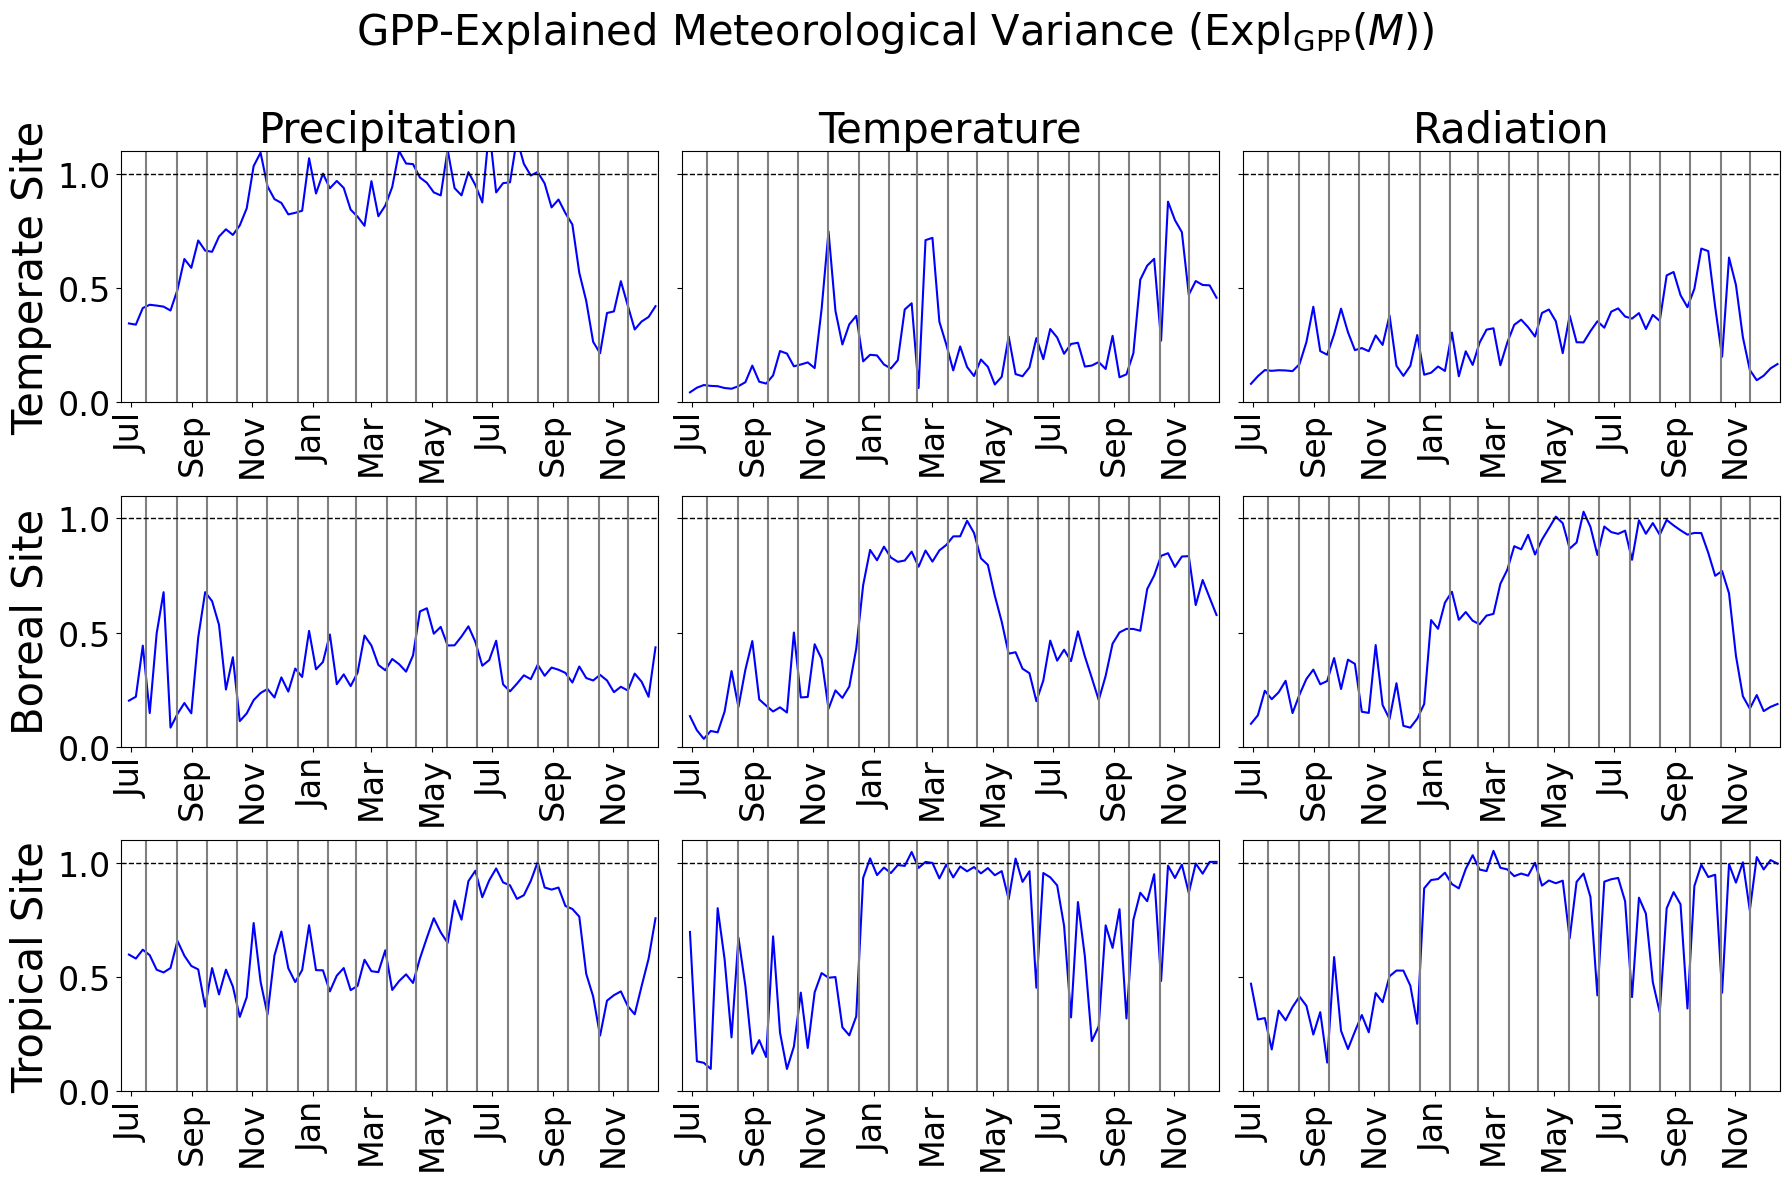

In [34]:
period = int(data['PERIOD'])  # change this to the period used in the model

sites = ['temperate', 'boreal', 'tropical']
variables = ['Precipitation', 'Temperature', 'Radiation']

fontsize=30
fontsize_ticks=24

fig, ax = plt.subplots(3, 3, figsize=(18, 12), sharex=False, sharey=True)
fig.suptitle(r'GPP-Explained Meteorological Variance ($\text{Expl}_{\text{GPP}}(M)$)', fontsize=fontsize)

for col, var in enumerate(variables):          # loop over rows (variables)
    for row, site in enumerate(sites):         # loop over columns (sites)
        y = data_models['explained_variance_test'][site][:, col]
        n_times = len(y)
        x = np.arange(n_times)
        x = (544 - n_times * period) + x * period + period / 2 - 179 #magic mapping 
        ax[row, col].plot(x, y, color='blue', label=site)
        # ax[row, col].legend()

        # Use your decorate_plot
        xlabel = (row == 2)  # only bottom row gets month labels
        decorate_plot(ax[row, col], lim=[-179, 364], xlabel=True, 
                      fontsize=fontsize_ticks, xtick_freq=2, 
                      fontsize_yticks=fontsize_ticks)
        ax[row, col].set_ylim(0, 1.1)
        ax[row, col].axhline(1, color='black', lw=1.0, ls='--')

        # Titles for top row
        if row == 0:
            ax[row, col].set_title(var, fontsize=fontsize)
        # Labels for left column
        if col == 0:
            ax[row, col].set_ylabel(f'{site.capitalize()} Site', fontsize=fontsize)

fig.tight_layout(rect=[0, 0, 1, 0.96])

plt.savefig("./explained_gpp_variance.pdf", dpi=300)